# Classify water as hot or cold (from the sound of pouring) - Part 1

## Inspiration:
This project is an attempt to start using the skills I'm learning in Fast.ai's stellar [Practical Deep Learning for Coders, v3](https://course.fast.ai/) [MOOC](https://en.wikipedia.org/wiki/Massive_open_online_course).

While thinking over the kinds of projects I could build, I kept coming up against the limits of the data I could get or generate. Serendipity struck when I recalled an [NPR piece](https://www.npr.org/2014/07/05/328842704/what-does-cold-sound-like) on the sound water makes when poured at different temperatures.

Clearly the sound water makes is information dense enough for people to tell hot from cold. Perhaps it's even information dense enough to determine the rough temparature of that water, or at least for a computer to make the same hot v cold categorization.

Such a project would be easy enough to generate data for, so I got to work with my phone, some cups, an electric kettle, and some free time. After getting a small initial data set to experiment with, I set off using the shiny new ML skills I'm learning.

## Design:
This particular ML pipeline/project design had several inspirations:

* Audio classification via spectrograms (to make this an image classification problem)
    * Mentioned in passing in [Fast.ai lesson 2]() at roughly 1:39:00
* Image regression: getting a continuious scalar output (temp in F)
    * Outlined in [Fast.ai lesson 3](https://course.fast.ai/videos/?lesson=3) at roughly 1:34:00
        * The continuious output in the lesson was x,y coordinates for the center of a head, but that is roughly the same problem domain
    * Alas, this particular idea didn't work out with my data/problem domain

## Dependencies

* Fast.ai `conda install -c fastai fastai`
    * Important note: fastai requires Python 3.6.*
* pytorch ([installation instructions](https://pytorch.org/))
* PyDub `conda install pydub`
    * There are some [additional dependencies](https://github.com/jiaaro/pydub#dependencies) needed after conda install
        * ffmpeg: `conda install ffmpeg`
        * libav: `conda install av`
* AudioSegment `pip install audiosegment`
    * There are additional manually installed [dependencies](https://github.com/MaxStrange/AudioSegment#notes): `conda install librosa` and [sox](http://sox.sourceforge.net/)


# Notebook Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
print("cuda available") if torch.cuda.is_available() else print("cuda not available")

print(torch.cuda.get_device_name(0))
print('Memory Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Memory Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda available
GeForce GTX 970
Memory Allocated: 0.0 GB
Memory Cached:    0.0 GB


In [4]:
dataPath = Path('data/'); print(dataPath)
audioPath = dataPath/'audio'; print(audioPath)
spectrogramPath = dataPath/'spectrograms'; print(spectrogramPath)

data
data\audio
data\spectrograms


# Take a look at the data

In [5]:
import os
import IPython

for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-glass-1.m4a", fileName):
        fullName = audioPath/fileName
        print(fullName)
        IPython.display.display(IPython.display.Audio(fullName))


data\audio\175f-glass-1.m4a


data\audio\40f-glass-1.m4a


data\audio\45f-glass-1.m4a


data\audio\73f-glass-1.m4a


# Generate spectrograms of the data (attempt 1)

By generating spectrograms of the audio, we can map this audio classification problem to an image classification problem.

I searched around a bit online, and came across a nice wrapper for PyDub's AudioSegment object that has a convinent `spectrogram` method.

data\audio\175f-ceramicMug-1.m4a


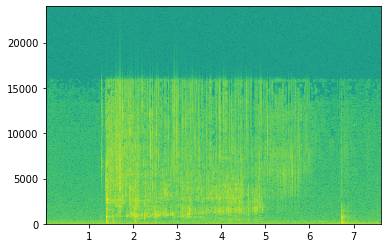

data\audio\195f-ceramicMug-1.m4a


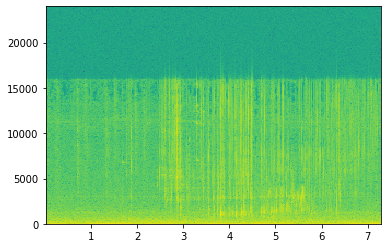

data\audio\212f-ceramicMug-1.m4a


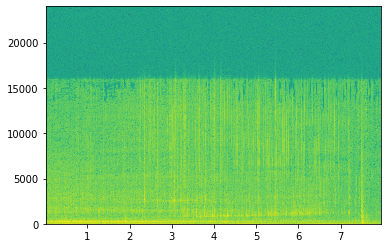

data\audio\40f-ceramicMug-1.m4a


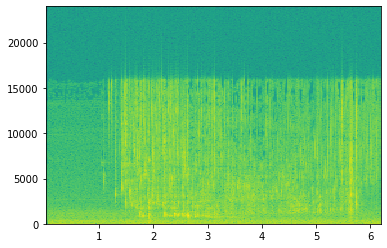

data\audio\45f-ceramicMug-1.m4a


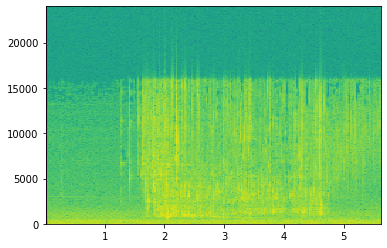

data\audio\73f-ceramicMug-1.m4a


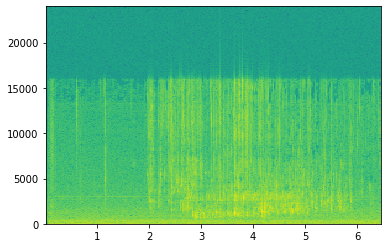

In [114]:
import os
import audiosegment as audiosegment
import matplotlib.pyplot

def GenerateSpectrogramOfFile(filePath):
    print(filePath)
    audioData = audiosegment.from_file(filePath)

    # This snippet is from https://github.com/MaxStrange/AudioSegment#spectrogram, used under MIT license
    freqs, times, amplitudes = audioData.spectrogram(window_length_s=0.025, overlap=0.05)
    amplitudes = 10 * np.log10(amplitudes + 1e-9)

    # Plot the spectrogram
    plt.pcolormesh(times, freqs, amplitudes)
    plt.show()
    plt.close('all')

for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-ceramicMug-1.m4a", fileName):
        fullName = audioPath/fileName
        GenerateSpectrogramOfFile(fullName)


## Plot an FFT of the data
Let's see if something is unique about the component frequencies, regardless of time

data\audio\175f-ceramicMug-1.m4a


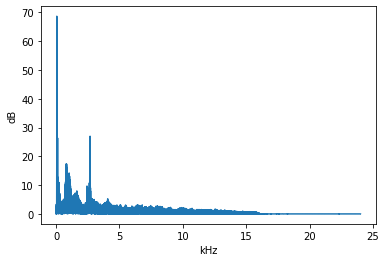

data\audio\195f-ceramicMug-1.m4a


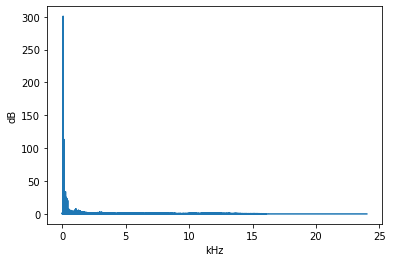

data\audio\212f-ceramicMug-1.m4a


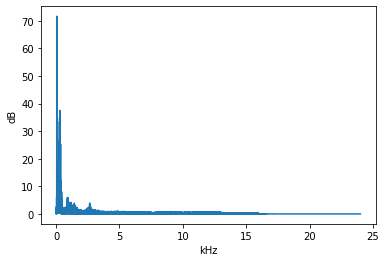

data\audio\40f-ceramicMug-1.m4a


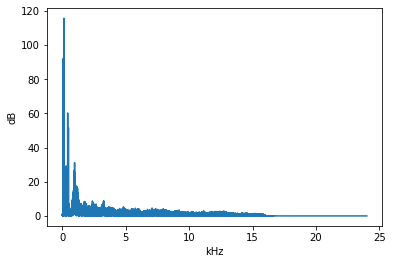

data\audio\45f-ceramicMug-1.m4a


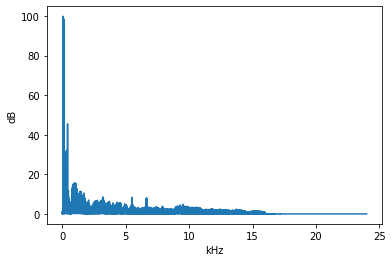

data\audio\73f-ceramicMug-1.m4a


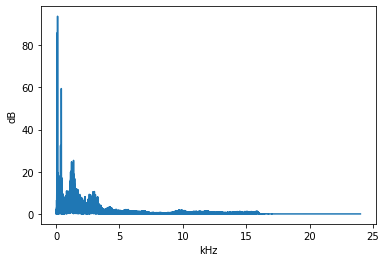

In [115]:
import os
import audiosegment
import numpy as np
import matplotlib.pyplot


def GenerateFFT(filePath):
    print(fullName)
    audioData = audiosegment.from_file(filePath)

    # This snippet is from the https://github.com/MaxStrange/AudioSegment#fft docs, used under MIT license
    hist_bins, hist_vals = audioData.fft()
    hist_vals_real_normed = np.abs(hist_vals) / len(hist_vals)
    plt.plot(hist_bins / 1000, hist_vals_real_normed)
    plt.xlabel("kHz")
    plt.ylabel("dB")
    plt.show()

for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-ceramicMug-1.m4a", fileName):
        fullName = audioPath/fileName
        GenerateFFT(fullName)


It looks like there is some kind of correlation between what frequencies are present and what temparature the water is, but I have a hunch time is important here. In my own admittedly subjective experience, the gradually changing pitch as the water pours clues me into hot vs cold.

The FFT alone loses that time information, so we will proceed using spectrograms.

## Generate spectrograms for each audio sample
And save them in a folder that lives alongside the audio data

In [31]:
import os
import audiosegment
import matplotlib.pyplot

def GenerateSpectrogramOfFile(audioFilePath):
    print('Generating spectrogram for: ' + str(audioFilePath))
    audioData = audiosegment.from_file(audioFilePath)

    # This snippet is from https://github.com/MaxStrange/AudioSegment#spectrogram, used under MIT license
    freqs, times, amplitudes = audioData.spectrogram(window_length_s=0.025, overlap=0.05)
    amplitudes = 10 * np.log10(amplitudes + 1e-9)

    # Disable axes and borders to only plot relevant info 
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    
    # Plot the spectrogram
    ax.pcolormesh(times, freqs, amplitudes)
    
    # Save the generated spectrogram
    spectrogramSavePath = (
        str(spectrogramPath)
        +
        '/'
        +
        os.path.splitext(os.path.basename(audioFilePath))[0]
        + '.png')
    print('Saving spectrogram as: ' + str(spectrogramSavePath))
    plt.savefig(spectrogramSavePath)
    plt.close()


for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-[a-zA-Z]+-\d.m4a", fileName):
        fullName = audioPath/fileName
        GenerateSpectrogramOfFile(fullName)


Generating spectrogram for: data\audio\175f-ceramicMug-1.m4a
Saving spectrogram as: data\spectrograms/175f-ceramicMug-1.png
Generating spectrogram for: data\audio\175f-glass-1.m4a
Saving spectrogram as: data\spectrograms/175f-glass-1.png
Generating spectrogram for: data\audio\175f-glassMug-1.m4a
Saving spectrogram as: data\spectrograms/175f-glassMug-1.png
Generating spectrogram for: data\audio\175f-smallThermos-1.m4a
Saving spectrogram as: data\spectrograms/175f-smallThermos-1.png
Generating spectrogram for: data\audio\195f-ceramicMug-1.m4a
Saving spectrogram as: data\spectrograms/195f-ceramicMug-1.png
Generating spectrogram for: data\audio\195f-ceramicMug-2.m4a
Saving spectrogram as: data\spectrograms/195f-ceramicMug-2.png
Generating spectrogram for: data\audio\195f-glassMug-1.m4a
Saving spectrogram as: data\spectrograms/195f-glassMug-1.png
Generating spectrogram for: data\audio\195f-smallThermos-1.m4a
Saving spectrogram as: data\spectrograms/195f-smallThermos-1.png
Generating spectro

## Let's do some ML!

In [32]:
def label_via_re(file_name):
    pattern = re.compile(r'.*[\\|/](\d+)f-[a-zA-Z]+-\d.png')
    return pattern.search(str(file_name)).group(1)

In [34]:
print(label_via_re(spectrogramPath/'175f-ceramicMug-1.png'))

175


In [74]:
# Make a data bunch of all the spectrograms, and label them with their temparature via regex
# Mark the labels as floats, in order to ensure they are treated as scalar values

data = (ImageList
    .from_folder(spectrogramPath)
    .split_by_rand_pct()
    .label_from_func(label_via_re, label_cls=FloatList) # Key step: we specify the labels are floats (rather than categories)
    .databunch(bs=16) # Use a small batch size, since we don't have much data and the fastai framework will complain otherwise
).normalize(imagenet_stats)

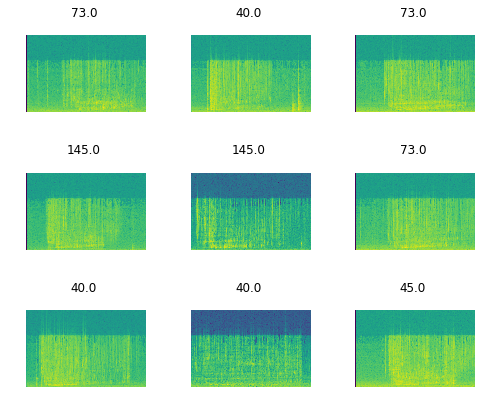

In [75]:
data.show_batch(rows=3, figsize=(7,6))

In [78]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


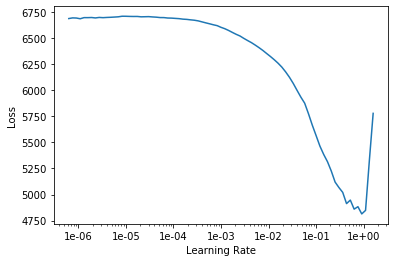

In [79]:
learn.lr_find()
learn.recorder.plot()

In [82]:
# The steepest point appears to be roughly 1e-1
learn.fit_one_cycle(5, slice(1e-1))

In [83]:
learn.save("initial-model")

## Not a good start :/

It looks like the spectrograms could use some tweaking. There's a lot of noise, and a sudden transition where there's no information at ~16,000 Hz.

After some digging online and into the implementation of the audiosegemnt library, libROSA looks to be the best library to switch to for greater control. It has a very well documented [melspectrogram](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html) function, which looks to be the best primative to work with in these next steps.

data\audio\175f-ceramicMug-1.m4a


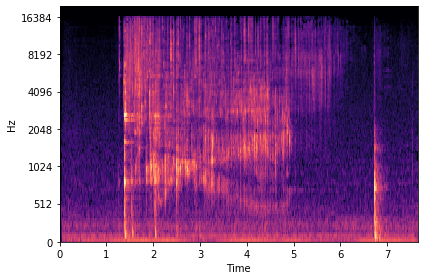

data\audio\195f-ceramicMug-1.m4a


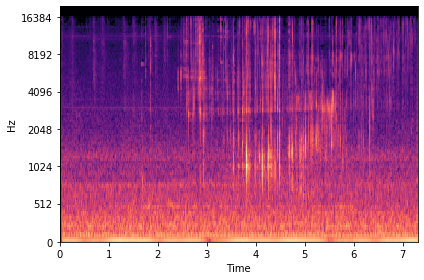

data\audio\212f-ceramicMug-1.m4a


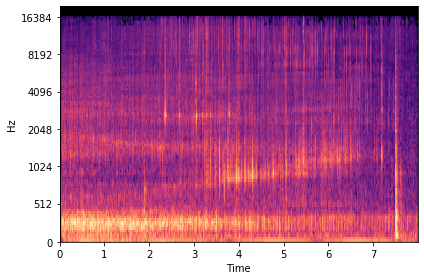

data\audio\40f-ceramicMug-1.m4a


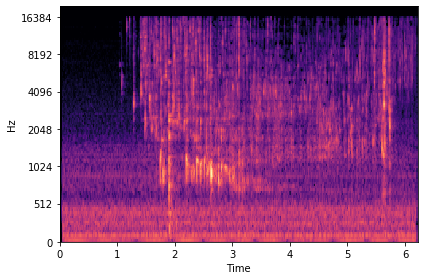

data\audio\45f-ceramicMug-1.m4a


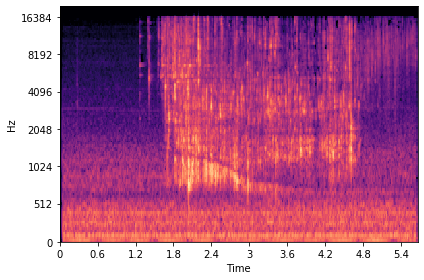

data\audio\73f-ceramicMug-1.m4a


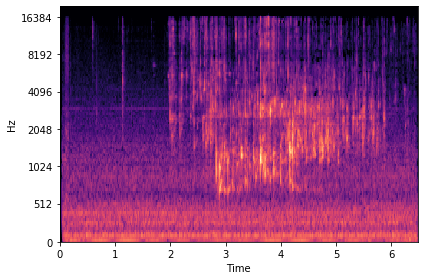

In [116]:
import IPython;
import librosa
import librosa.display
import matplotlib.pyplot
import numpy
import os

def libROSA_spectrogram(filePath):
    print(filePath)

    max_frequency = 20000;
    
    # Load the audio, generate a spectrogram in absolute terms, translate to DB (to match the logarithmic nature of hearing)
    audio_data, sample_rate = librosa.load(filePath, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128, fmax=max_frequency)
    amplitude_in_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Display the spectrogram
    librosa.display.specshow(amplitude_in_db, x_axis='time', y_axis='mel', sr=sample_rate, fmax=max_frequency)
    plt.tight_layout()
    plt.show()
    
    # Display the accompanying audio
    IPython.display.display(IPython.display.Audio(filePath))

for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-ceramicMug-1.m4a", fileName):
        fullName = audioPath/fileName
        libROSA_spectrogram(fullName)


Very cool! There appaers to be far less noise masking the structure of the sound. We also learned some invariants in the data: it appears my iPhone audio recordings truncate at 16,384Hz, and nothing interesting appears to be present below 256Hz. 

Let's set those bounds, disable the axes, and take a look at the result:

In [87]:
# Constants
np.random.seed(10)

min_frequency=256
max_frequency = 16384
samples_between_frames = 256
fft_window_size = 2048

data\audio\175f-ceramicMug-1.m4a


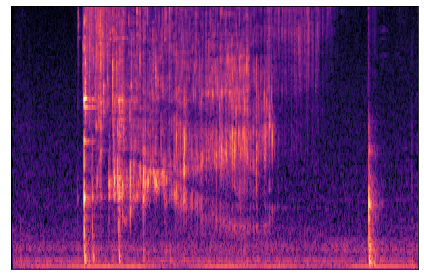

data\audio\195f-ceramicMug-1.m4a


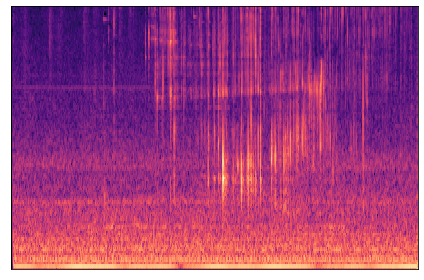

data\audio\212f-ceramicMug-1.m4a


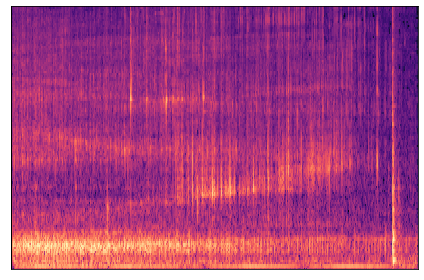

data\audio\40f-ceramicMug-1.m4a


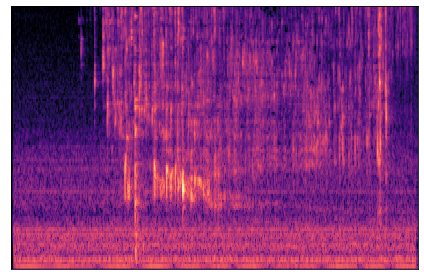

data\audio\45f-ceramicMug-1.m4a


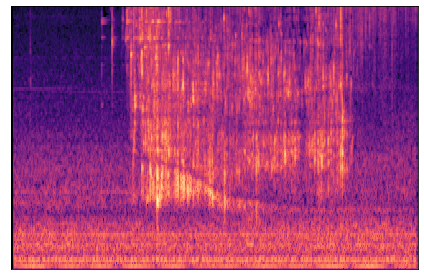

data\audio\73f-ceramicMug-1.m4a


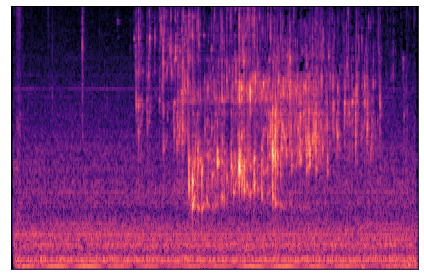

In [78]:
import os
import librosa
import librosa.display
import numpy
import matplotlib.pyplot

def libROSA_spectrogram(filePath):
    print(filePath)
    
    # Load the audio, generate a spectrogram in DB (to match the logarithmic nature of human hearing)
    audio_data, sample_rate = librosa.load(filePath, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128, fmax=max_frequency,
                                                 hop_length=samples_between_frames, n_fft=fft_window_size)
    amplitude_in_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Display the spectrogram with min and max frequency bounds applied
    librosa.display.specshow(amplitude_in_db, x_axis=None, y_axis=None, sr=sample_rate, fmin=min_frequency, fmax=max_frequency)
    plt.tight_layout()
    plt.show()

for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-ceramicMug-1.m4a", fileName):
        fullName = audioPath/fileName
        libROSA_spectrogram(fullName)

## Doing ML, part duex:

In [79]:
import os
import audiosegment
import matplotlib.pyplot

def generate_and_save_libROSA_spectrogram(audioFilePath):
    print('Generating spectrogram for: ' + str(audioFilePath))
    audioData = audiosegment.from_file(audioFilePath)

    max_frequency = 16384;

    # Load the audio, generate a spectrogram in DB (to match the logarithmic nature of human hearing)
    audio_data, sample_rate = librosa.load(audioFilePath, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128, fmax=max_frequency,
                                             hop_length=samples_between_frames, n_fft=fft_window_size)
    amplitude_in_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Generate the spectrogram with min and max frequency bounds applied
    librosa.display.specshow(amplitude_in_db, x_axis=None, y_axis=None, sr=sample_rate, fmin=min_frequency, fmax=max_frequency)
    plt.tight_layout()
    
    # Save the generated spectrogram
    spectrogramSavePath = (
        str(spectrogramPath)
        +
        '/'
        +
        os.path.splitext(os.path.basename(audioFilePath))[0]
        + '.png')
    print('Saving spectrogram as: ' + str(spectrogramSavePath))
    plt.savefig(spectrogramSavePath)
    plt.close()


for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-[a-zA-Z]+-\d.m4a", fileName):
        fullName = audioPath/fileName
        generate_and_save_libROSA_spectrogram(fullName)

Generating spectrogram for: data\audio\175f-ceramicMug-1.m4a
Saving spectrogram as: data\spectrograms/175f-ceramicMug-1.png
Generating spectrogram for: data\audio\175f-glass-1.m4a
Saving spectrogram as: data\spectrograms/175f-glass-1.png
Generating spectrogram for: data\audio\175f-glassMug-1.m4a
Saving spectrogram as: data\spectrograms/175f-glassMug-1.png
Generating spectrogram for: data\audio\175f-smallThermos-1.m4a
Saving spectrogram as: data\spectrograms/175f-smallThermos-1.png
Generating spectrogram for: data\audio\195f-ceramicMug-1.m4a
Saving spectrogram as: data\spectrograms/195f-ceramicMug-1.png
Generating spectrogram for: data\audio\195f-ceramicMug-2.m4a
Saving spectrogram as: data\spectrograms/195f-ceramicMug-2.png
Generating spectrogram for: data\audio\195f-glassMug-1.m4a
Saving spectrogram as: data\spectrograms/195f-glassMug-1.png
Generating spectrogram for: data\audio\195f-smallThermos-1.m4a
Saving spectrogram as: data\spectrograms/195f-smallThermos-1.png
Generating spectro

In [80]:
def label_via_re(file_name):
    pattern = re.compile(r'.*[\\|/](\d+)f-[a-zA-Z]+-\d.png')
    return pattern.search(str(file_name)).group(1)

print(label_via_re(spectrogramPath/'175f-glass-1.png'))

175


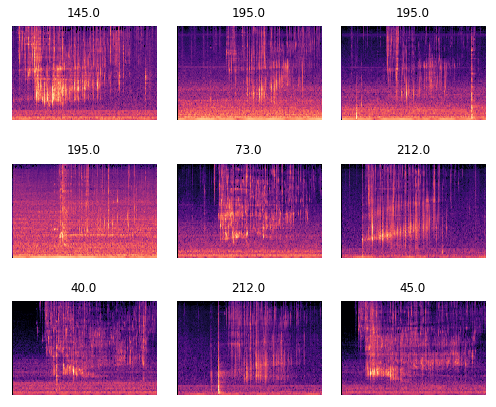

In [45]:
# Make a data bunch of all the spectrograms, and label them with their temparature via regex
# Mark the labels as floats, in order to ensure they are treated as scalar values

data = (ImageList
    .from_folder(spectrogramPath)
    .split_by_rand_pct()
    .label_from_func(label_via_re, label_cls=FloatList) # Key step: we specify the labels are floats (rather than categories)
    .databunch(bs=16) # Use a small batch size, since we don't have much data and the fastai framework will complain otherwise
).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

In [56]:
learn = cnn_learner(data, models.resnet34)
learn.fit_one_cycle(3)

No dice doing image regression :(
It's time to try a different approach.

### Changing Gears: Detect temp -> Hot vs Cold

Instead of inferring a temparature from the spectrogram, let's narrow the scope. In my own personal experience, I can only tell roughly "hot" from "cold", so treating this as a regression problem may be too ambitious.

In [100]:
# Constants
np.random.seed(369)

min_frequency=256
max_frequency = 16384
samples_between_frames = 256
fft_window_size = 2048

In [105]:
import os
import audiosegment
import matplotlib.pyplot

def generate_and_save_libROSA_spectrogram(audioFilePath):
    print('Generating spectrogram for: ' + str(audioFilePath))
    audioData = audiosegment.from_file(audioFilePath)

    max_frequency = 16384;

    # Load the audio, generate a spectrogram in DB (to match the logarithmic nature of human hearing)
    audio_data, sample_rate = librosa.load(audioFilePath, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128, fmax=max_frequency,
                                             hop_length=samples_between_frames, n_fft=fft_window_size)
    amplitude_in_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Generate the spectrogram with min and max frequency bounds applied
    librosa.display.specshow(amplitude_in_db, x_axis=None, y_axis=None, sr=sample_rate, fmin=min_frequency, fmax=max_frequency)
    plt.tight_layout()
    
    # Save the generated spectrogram
    spectrogramSavePath = (
        str(spectrogramPath)
        +
        '/'
        +
        os.path.splitext(os.path.basename(audioFilePath))[0]
        + '.png')
    print('Saving spectrogram as: ' + str(spectrogramSavePath))
    plt.savefig(spectrogramSavePath)
    plt.close()


for fileName in os.listdir(audioPath):
    if re.match(r"\d+f-[a-zA-Z]+-\d.m4a", fileName):
        fullName = audioPath/fileName
        generate_and_save_libROSA_spectrogram(fullName)

Generating spectrogram for: data\audio\175f-ceramicMug-1.m4a
Saving spectrogram as: data\spectrograms/175f-ceramicMug-1.png
Generating spectrogram for: data\audio\175f-glass-1.m4a
Saving spectrogram as: data\spectrograms/175f-glass-1.png
Generating spectrogram for: data\audio\175f-glassMug-1.m4a
Saving spectrogram as: data\spectrograms/175f-glassMug-1.png
Generating spectrogram for: data\audio\175f-smallThermos-1.m4a
Saving spectrogram as: data\spectrograms/175f-smallThermos-1.png
Generating spectrogram for: data\audio\195f-ceramicMug-1.m4a
Saving spectrogram as: data\spectrograms/195f-ceramicMug-1.png
Generating spectrogram for: data\audio\195f-ceramicMug-2.m4a
Saving spectrogram as: data\spectrograms/195f-ceramicMug-2.png
Generating spectrogram for: data\audio\195f-glassMug-1.m4a
Saving spectrogram as: data\spectrograms/195f-glassMug-1.png
Generating spectrogram for: data\audio\195f-smallThermos-1.m4a
Saving spectrogram as: data\spectrograms/195f-smallThermos-1.png
Generating spectro

In [106]:
def hot_or_cold_re(file_name):
    pattern = re.compile(r'.*[\\|/](\d+)f-[a-zA-Z]+-\d.png')
    temp = pattern.search(str(file_name)).group(1)
    return 'hot' if int(temp) > 100 else 'cold'

print(hot_or_cold_re(spectrogramPath/'75f-glass-1.png'))
print(hot_or_cold_re(spectrogramPath/'175f-glass-1.png'))

cold
hot


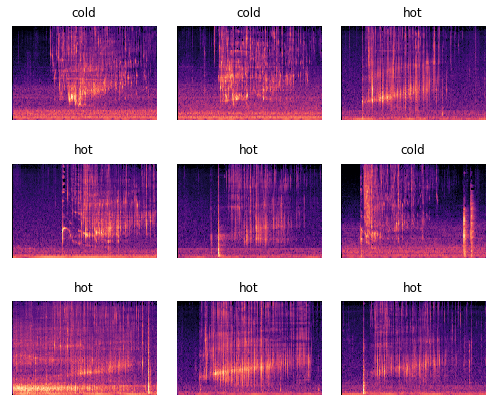

In [107]:
data = (ImageList
    .from_folder(spectrogramPath)
    .split_by_rand_pct()
    .label_from_func(hot_or_cold_re)
    .databunch(bs=16) # Use a small batch size, since we don't have much data and the fastai framework will complain otherwise
).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

In [108]:
print(data.classes)
len(data.classes),data.c

['cold', 'hot']


(2, 2)

In [109]:
learn = cnn_learner(data, models.resnet34)
learn.fit_one_cycle(3)

In [110]:
interp = ClassificationInterpretation.from_learner(learn)

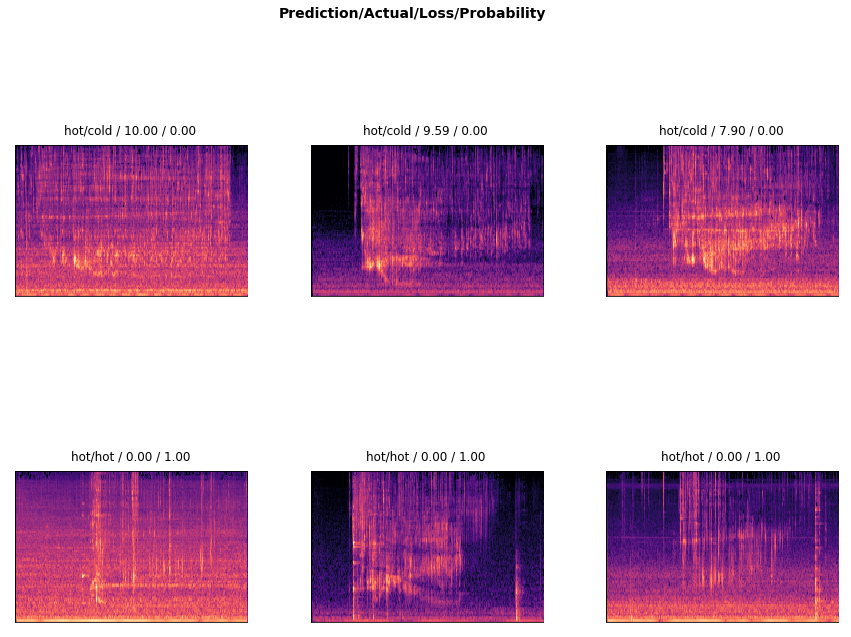

In [111]:
interp.plot_top_losses(6, figsize=(15,11))

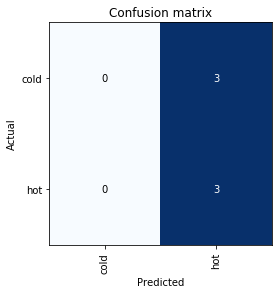

In [112]:
interp.plot_confusion_matrix()

In [113]:
interp.most_confused(min_val=2)

[('cold', 'hot', 3)]

## Next Steps!
I think it's time to collect some more data, the limited size of this initial data set is really hurting our ability to train and validate. I am fairly certain that it won't be practical to get enough data to treat this as a regression problem, so let's stick with classification into 'hot' or 'cold'.

If more data doesn't do the trick, I think it's a good idea to give some domain-specific transfer learning a try. Perhaps we can take the pre-trained resNet network we are currently starting with, train it on a different, larger and well-studied audio dataset, and that will transfer cleanly to this problem domain. Then we'd be able to use a relatively small amount of data to train the network only on classes, rather than also having to tackle the primitive task of extracting features from spectrograms.

From searching online, it looks like Kaggle has a city sounds dataset. I may give that a try, so long as training on it isn't super time consuming (I only have a GTX 970).

Onward to build-log-2!